In [ ]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import os
import glob
import numpy as np

In [ ]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *

In [ ]:
def down_block(x, filters, use_maxpool = True):
    x = Conv2D(filters, 3, padding= 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(filters, 3, padding= 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    if use_maxpool == True:
        return  MaxPooling2D(strides= (2,2))(x), x
    else:
        return x

In [ ]:
def up_block(x,y, filters):
    x = UpSampling2D()(x)
    x = Concatenate(axis = 3)([x,y])
    x = Conv2D(filters, 3, padding= 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(filters, 3, padding= 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    return x

In [ ]:
def Unet(input_size = (256, 256, 3)):
    filter = [8,16,32,64,128]
    # encode
    input = Input(shape = input_size)
    x, temp1 = down_block(input, filter[0])
    x = MaxPooling2D()(x)
    x = Conv2D(64, 3, padding='same', activation='relu')(x)
    # x = Conv2D(64, 3, padding='same', activation='relu')(x)
    x, temp2 = down_block(x, filter[1])
    x = MaxPooling2D()(x)
    x = Conv2D(64, 3, padding='same', activation='relu')(x)
    # x = Conv2D(64, 3, padding='same', activation='relu')(x)
    x, temp3 = down_block(x, filter[2])
    x = Conv2D(128, 3, padding='same', activation='relu')(x)
    # x = Conv2D(128, 3, padding='same', activation='relu')(x)
    x, temp4 = down_block(x, filter[3])
    x = Conv2D(256, 3, padding='same', activation='relu')(x)
    # x = Conv2D(256, 3, padding='same', activation='relu')(x)
    x = down_block(x, filter[4], use_maxpool= False)
    x = Conv2D(512, 3, padding='same', activation='relu')(x)
    # x = Conv2D(512, 3, padding='same', activation='relu')(x)
    # decode
    x = up_block(x, temp4, filter[3])
    x = Conv2DTranspose(filter[3], 3, padding='same')(x)
    x = Conv2DTranspose(filter[3], 3, padding='same')(x)
    # x = Conv2DTranspose(filter[3], 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = up_block(x, temp3, filter[2])
    x = Conv2DTranspose(filter[2], 3, padding='same')(x)
    x = Conv2DTranspose(filter[2], 3, padding='same')(x)
    # x = Conv2DTranspose(filter[2], 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D()(x)
    x = up_block(x, temp2, filter[1])
    x = Conv2DTranspose(filter[1], 3, padding='same')(x)
    x = Conv2DTranspose(filter[1], 3, padding='same')(x)
    x = Conv2DTranspose(filter[1], 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D()(x)
    x = up_block(x, temp1, filter[0])
    x = Conv2DTranspose(filter[0], 3, padding='same')(x)
    x = Conv2DTranspose(filter[0], 3, padding='same')(x)
    x = Conv2DTranspose(filter[0], 3, padding='same')(x)
    output = Conv2D(3, 1)(x)

    model = models.Model(input, output, name = 'unet')
    model.summary()
    return model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir = '/content/drive/MyDrive/dataset'

In [ ]:
classes=['freshapples',
         'freshbanana',
         'freshoranges',
         ]

In [ ]:
train_data = []

for i in classes:
  path = dir + '/train/' + i + '/*.png'
  for filename in glob.glob(path):
    img = cv2.imread(filename)
    img = cv2.resize(img, (256, 256))
    train_data.append(img)
train_data = np.array(train_data)
print(train_data.shape)

(4740, 256, 256, 3)


In [ ]:
x_train = np.array([np.array(val) for val in train_data])

In [ ]:
for i in range(10):
  cv2_imshow(x_train[i])

In [ ]:
model = Unet()

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 32)         0         ['batch_normalization[0][0]

In [ ]:
def scheduler(epoch, lr):
  if epoch < 70:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
checkpoint_path =  '/content/drive/MyDrive/DL_project/unet/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 verbose=1)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-03),
    loss='mse'
)

In [ ]:
# history = model.fit(x_train, x_train,
#           epochs=150,
#           batch_size=30,
#           validation_split=0.1,
#           callbacks=[lr_schedule, cp_callback])

Epoch 1/150
143/143 [==============================] - ETA: 0s - loss: 4596.2856
Epoch 1: saving model to /content/drive/MyDrive/DL_project/unet/cp.ckpt
143/143 [==============================] - 147s 737ms/step - loss: 4596.2856 - val_loss: 2651.4338 - lr: 0.0010
Epoch 2/150
143/143 [==============================] - ETA: 0s - loss: 523.3066
Epoch 2: saving model to /content/drive/MyDrive/DL_project/unet/cp.ckpt
143/143 [==============================] - 98s 685ms/step - loss: 523.3066 - val_loss: 354.1269 - lr: 0.0010
Epoch 3/150
143/143 [==============================] - ETA: 0s - loss: 388.8268
Epoch 3: saving model to /content/drive/MyDrive/DL_project/unet/cp.ckpt
143/143 [==============================] - 100s 698ms/step - loss: 388.8268 - val_loss: 1150.8734 - lr: 0.0010
Epoch 4/150
143/143 [==============================] - ETA: 0s - loss: 286.4181
Epoch 4: saving model to /content/drive/MyDrive/DL_project/unet/cp.ckpt
143/143 [==============================] - 98s 687ms/step -

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) - 40)
plt.plot(epochs, loss[:-49], label='Training loss')
plt.plot(epochs, val_loss[:-40], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import pandas as pd

hist_df = pd.DataFrame(history.history)
hist_csv_file = '/content/drive/MyDrive/DL_project/history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [ ]:
# model = tf.keras.models.load_model('/content/drive/MyDrive/DL_project/unet/cp.ckpt/')

In [ ]:
normal_test_apple = []

path = '/content/drive/MyDrive/dataset/test/freshapples' + '/*.png'
for filename in glob.glob(path):
  img = cv2.imread(filename)
  img = cv2.resize(img, (256, 256))
  normal_test_apple.append(img)

normal_test_apple = np.array(normal_test_apple)
print(normal_test_apple.shape)

(395, 256, 256, 3)


In [ ]:
abnormal_test_apple = []

path = '/content/drive/MyDrive/abnormal_test_data/apple' + '/*.png'
for filename in glob.glob(path):
  img = cv2.imread(filename)
  img = cv2.resize(img, (256, 256))
  img = img[:, :, ::-1]
  abnormal_test_apple.append(img)

abnormal_test_apple = np.array(abnormal_test_apple)
print(abnormal_test_apple.shape)

(395, 256, 256, 3)


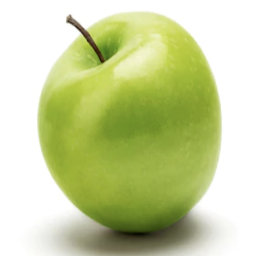

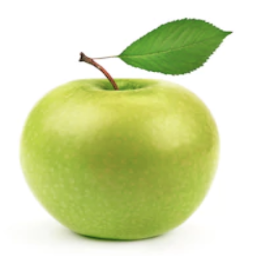

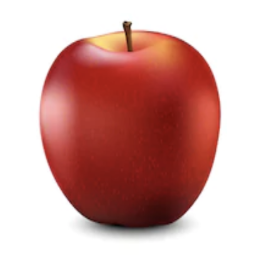

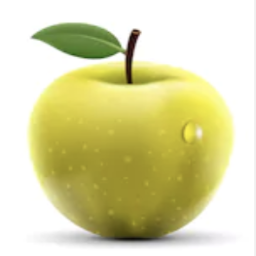

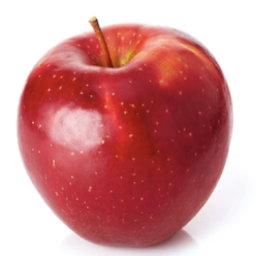

In [ ]:
for i in range(5):
  cv2_imshow(normal_test_apple[i])

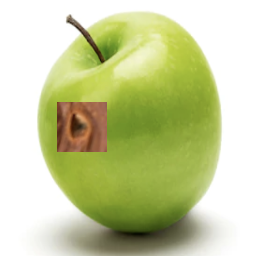

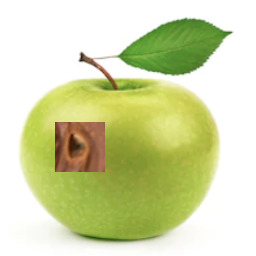

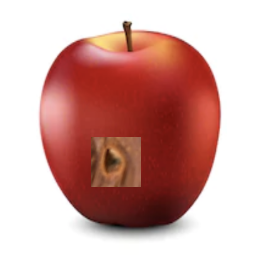

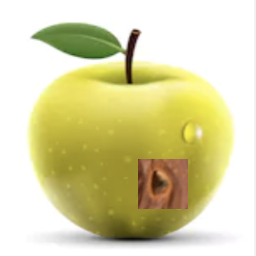

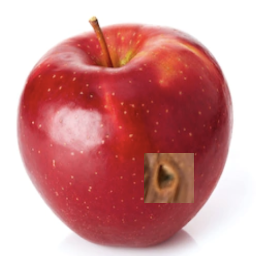

In [ ]:
for i in range(5):
  cv2_imshow(abnormal_test_apple[i])

In [ ]:
reconstructions = model.predict(normal_test_apple)
reconstructions = np.array(reconstructions, dtype = 'float32')
normal_test_apple = np.array(normal_test_apple, dtype = 'float32')
normal_loss = tf.keras.losses.mse(reconstructions, normal_test_apple)
print(normal_loss.shape)

13/13 [==============================] - 19s 342ms/step
(395, 256, 256)


(array([[250.,   1.,   0., ...,   0.,   0.,   0.],
        [249.,   2.,   1., ...,   0.,   0.,   1.],
        [250.,   2.,   1., ...,   0.,   0.,   0.],
        ...,
        [181.,   8.,  29., ...,   0.,   0.,   1.],
        [163.,  49.,  31., ...,   0.,   0.,   0.],
        [130.,  24.,  47., ...,   0.,   0.,   0.]]),
 array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.]),
 <a list of 256 BarContainer objects>)

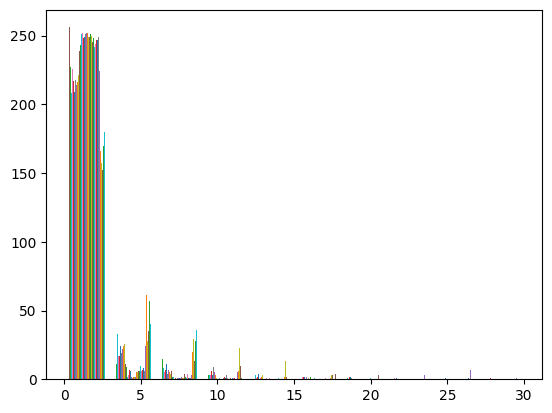

In [ ]:
plt.hist(normal_loss[0], range=(0,30))

In [ ]:
normal_score = []
for value in normal_loss:
  normal_score.append(np.array(value).mean())

<Figure size 640x480 with 0 Axes>

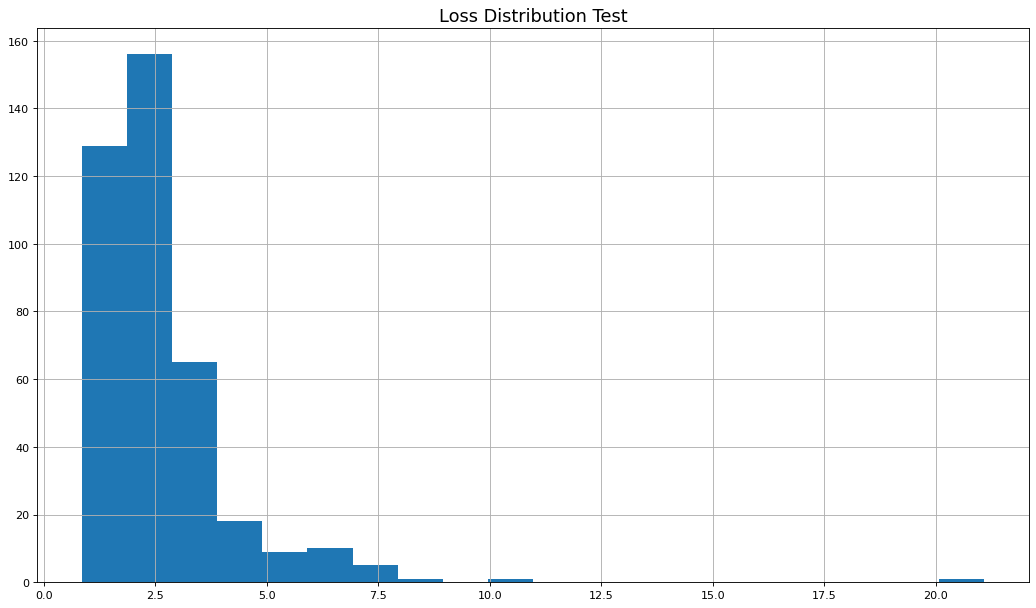

In [ ]:
import seaborn as sns

plt.figure()
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution Test', fontsize=16)
plt.grid()
plt.hist(normal_score, bins = 20);

In [ ]:
reconstructions_a = model.predict(abnormal_test_apple)
reconstructions_a = np.array(reconstructions_a, dtype = 'float32')
abnormal_test_apple = np.array(abnormal_test_apple, dtype = 'float32')
abnormal_loss = tf.keras.losses.mse(reconstructions_a, abnormal_test_apple)
print(abnormal_loss.shape)

13/13 [==============================] - 2s 186ms/step
(395, 256, 256)


In [ ]:
abnormal_score = []
for value in abnormal_loss:
  abnormal_score.append(np.array(value).mean())

<Figure size 640x480 with 0 Axes>

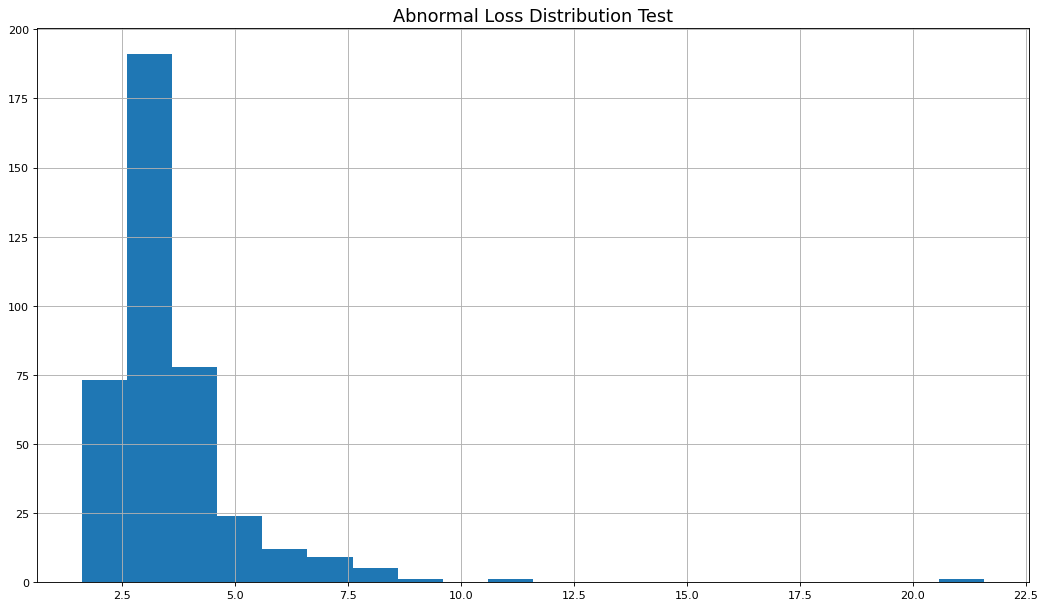

In [ ]:
plt.figure()
plt.figure(figsize=(16,9), dpi=80)
plt.title('Abnormal Loss Distribution Test', fontsize=16)
plt.grid()
plt.hist(abnormal_score, bins = 20);

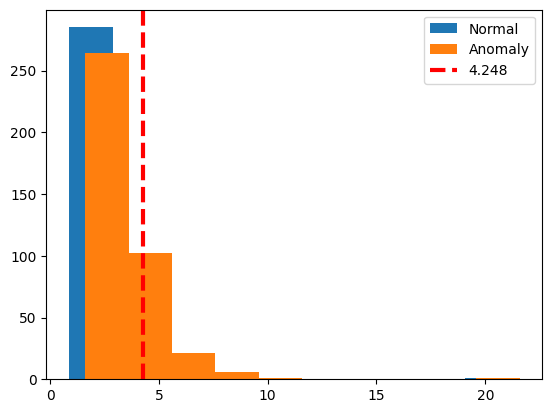

In [ ]:
threshold = np.mean(normal_score) + np.std(normal_score)

plt.hist(normal_score, bins = 10, label = 'Normal')
plt.hist(abnormal_score, bins = 10, label = 'Anomaly')
plt.axvline(threshold, color='r', linewidth = 3, linestyle = 'dashed', label = '{:0.3f}'.format(threshold))
plt.legend(loc = 'upper right')
plt.show()

In [ ]:
print(min(normal_score))
print(max(normal_score))

0.85143226
21.080433


In [ ]:
thresholds = np.linspace(min(normal_score), max(normal_score), 200)

In [ ]:
def predict_score(threshold, normal_score, abnormal_score):
  pred_label = []
  for score in normal_score:
    if score <= threshold:
      pred_label.append(0)
    else:
      pred_label.append(1)
  for score in abnormal_score:
    if score <= threshold:
      pred_label.append(0)
    else:
      pred_label.append(1)

  return pred_label

In [ ]:
a = np.zeros((395))
b = np.ones((395))
true_label = np.concatenate((a, b))
len(true_label)

790

In [ ]:
true_label = np.concatenate((np.zeros((len(normal_score))), np.ones((len(abnormal_score)))))
len(true_label)

In [ ]:
from sklearn import metrics

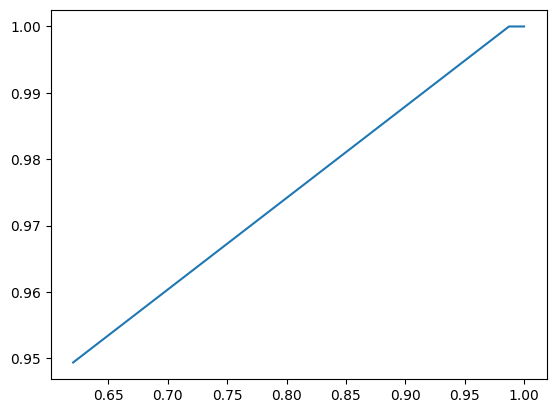

In [ ]:
fprs = []; tprs = []

for threshold in thresholds:
  pred_label = predict_score(threshold, normal_score, abnormal_score)
  fpr, tpr, _ = metrics.roc_curve(true_label, pred_label)
  fprs.append(fpr[1])
  tprs.append(tpr[1])

tprs = np.array([np.array(val) for val in tprs])
fprs = np.array([np.array(val) for val in fprs])
plt.plot(fprs, tprs)
plt.show()